In [480]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/../RKLM_Python/')
from data_assimilation import letkf
from scipy.linalg import sqrtm

import importlib
importlib.reload(letkf)
%matplotlib inline

In [481]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = int(50)
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = int(2 * 10**5)

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((int(N)*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((int(N/Nout),3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

In [482]:
def enkf_simple():
    None
    
# def forward_operator(X,R,M):
#     tmp = np.zeros_like(X.T)
#     print("tmp.shape = ", tmp.shape)
#     tmp[:,0] += np.sqrt(R) * np.random.randn(M)
#     print("tmp = ", tmp)
#     return lambda X : X + tmp

def forward_operator(X):
    return X[:,0]



In [483]:
STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 20
m = np.arange(1,NN+1)
m = 2*m

lenm = len(m)

#m = np.array([4])

rmse_x = np.zeros((lenm))
rmse_y = np.zeros((lenm))
rmse_z = np.zeros((lenm))

for lkl in range(lenm):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    cnt = 0
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        X = np.vstack((x,y,z))
#         print("State space mean in 3 coords = ", X.mean(axis=1))
#         print("Observation = ", obs[1,j+1])
        
#         obs_current = obs[1,j+1] + np.sqrt(R) * np.random.randn(M)

#         obs_current = np.array([obs[1,j+1],0.,0.]).reshape(-1,1)
        obs_current = np.array([obs[1,j+1]]).reshape(1,-1)
    
        analysis = letkf.analysis(X.T)
        forward_op = forward_operator
#         forward_op = forward_operator(X,R,M)
        analysis.forward_operator = forward_op
#         R_sp = np.diag([np.inf] * len(obs_current))
#         R_sp = np.zeros_like(np.ones((len(obs_current),len(obs_current))))
#         R_sp[0,0] = R
        R_sp = np.array([R]).reshape(1,1)
#         R_sp = np.ones((len(obs_current),len(obs_current))) * R
        X = analysis.analyse(obs_current,R_sp).T

###################################EnKF-PO#####################################

        # Calculate residual: (forward map of reference - yobs)
#         r = xh - obs[1,j+1]

#         # Hz^f_i + eta_i - y_{obs} = rpert
#         rpert = r + np.sqrt(R) * np.random.randn(M)
#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         P = P.sum(axis=1)/(M-1)
#         K = P[:,0] / (P[0,0] + R)
#         X -= np.outer(K,rpert)

###################################ESRF#######################################

#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         print("P.shape = dX * dX.T = ", P.shape)
#         P = P.sum(axis=1)/(M-1)
#         print("P.shape after sum = ", P.shape)
        
        
#         K = P[:,0] / (P[0,0] + R)
#         print("K.shape = ", K.shape)
        
#         # mean of analysis, eqn 7.8
#         xmean = np.mean(X,axis=1)
#         xmean = xmean - K*(xmean[0] - obs[1,j+1])
        
#         # Get the S matrix, eqn 7.22
#         Y = dX[0,:] / np.sqrt(M-1)
#         Y = Y.reshape(-1,1) # to make transpose sensible - 1D arrays not transposable!
#         S2 = np.linalg.inv(sqrtm(np.eye(M) + Y.T * Y / R)).real
#         dX = np.dot(dX,S2)
        
#         X = xmean.reshape(-1,1) * np.ones(1,M) + dX
        
##############################################################################

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)


In [484]:
rmse_letkf = [rmse_x, rmse_y, rmse_z]

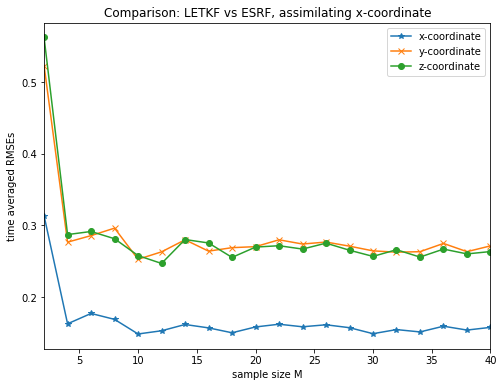

In [485]:
fig0a = plt.figure(figsize=(8,6))

plt.plot(m,rmse_x, '*-', label="x-coordinate")
plt.plot(m,rmse_y, 'x-', label="y-coordinate")
plt.plot(m,rmse_z, 'o-', label="z-coordinate")

# plt.plot(m,rmse_letkf[0], 'r*-', label="x-coordinate")
# plt.plot(m,rmse_letkf[1], 'rx-', label="y-coordinate")
# plt.plot(m,rmse_letkf[2], 'ro-', label="z-coordinate")

plt.xlim([2,40])
# plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("Comparison: LETKF vs ESRF, assimilating x-coordinate")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# legend_elements = [Line2D([0], [0], marker='*', color='k', label='x-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], marker='x', color='k', label='y-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], marker='o', color='k', label='z-coordinate',
#                           markerfacecolor='k', markersize=8),
#                    Line2D([0], [0], color='k', lw=4, label='ESRF'),
#                    Line2D([0], [0], color='r', lw=4, label='LETKF')]
# plt.legend(handles=legend_elements)

plt.legend()
plt.show()

In [486]:
A = np.arange(25).reshape(5,5)
print(A)
D = np.ones(5).reshape(-1,1) * 3
print(D)
print(A+D)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
[[ 3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12.]
 [13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22.]
 [23. 24. 25. 26. 27.]]


In [487]:
np.random.randint(-5,5)

2